In [1]:
bing_key = "10bab48a1a7d479fa36a04daf1ac01c4"

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
results = search_images_bing(bing_key, 'bear')
ims = results.attrgot('contentUrl')

In [4]:
print(f"{len(ims)} images retrieved")

150 images retrieved


In [5]:
dest = 'images/bear.jpg'
download_url(ims[0], dest)

Path('images/bear.jpg')

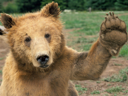

In [6]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [7]:
gun_types = 'ak-47', 'ar15', 'glock'
path = Path('guns')

if not path.exists():
    path.mkdir()
    for g in gun_types:
        dest = (path/g)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(bing_key, f'{g}')
        print(results)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#349) [Path('guns/ak-47/00e75145-3e43-44c1-bf6e-b33c5492c228.jpg'),Path('guns/ak-47/01df7af9-1ed0-4600-8a45-8c3b45cead78.png'),Path('guns/ak-47/05265ea2-3dce-453a-9e06-ecbc3d6d18f3.jpg'),Path('guns/ak-47/0570c2fc-a511-4acb-98a4-086729239da4.jpg'),Path('guns/ak-47/07fc369f-a84f-4de0-8002-8d0c7ad2e5dc.jpg'),Path('guns/ak-47/0a9b122d-b933-46e8-ae09-08499f006ab4.jpg'),Path('guns/ak-47/0b34d576-4215-47e9-9d27-3f137c7989f4.jpg'),Path('guns/ak-47/0b837210-cadd-420b-94c4-9d9dd457785d.jpg'),Path('guns/ak-47/0c383bbd-573e-45fe-944e-ccff3e47df5c.jpg'),Path('guns/ak-47/0d234974-d2fb-4770-ad6b-327abe2749f4.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
failed.map(Path.unlink)

(#0) []

In [11]:
guns = DataBlock(
          blocks=(ImageBlock, CategoryBlock),
          get_items=get_image_files,
          splitter=RandomSplitter(valid_pct=0.2, seed=42),
          get_y=parent_label,
          item_tfms=Resize(128))

In [12]:
dls = guns.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


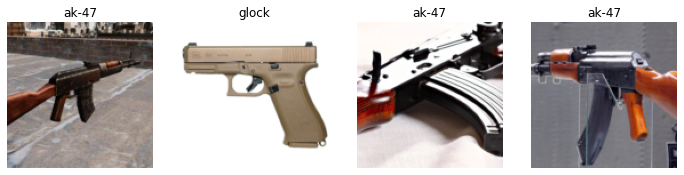

In [13]:
dls.train.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


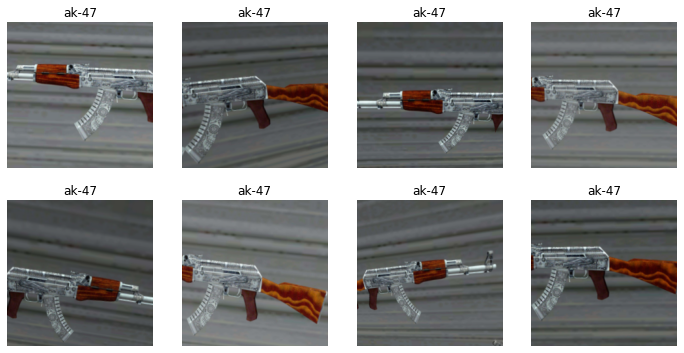

In [14]:
guns_aug = guns.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms())
dls = guns_aug.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(15)

C:\Users\dragos.mezei\anaconda3\envs\objectdetection\lib\site-packages\fastai\vision\learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.642309,0.632086,0.260870,00:27


C:\Users\dragos.mezei\anaconda3\envs\objectdetection\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.721013,0.438166,0.231884,00:31
1,0.638129,0.293882,0.130435,00:32
2,0.538806,0.224990,0.101449,00:34
3,0.478357,0.203216,0.086957,00:33
4,0.409674,0.223550,0.057971,00:33
5,0.345031,0.219749,0.057971,00:32
6,0.300706,0.190200,0.057971,00:32
7,0.263813,0.181940,0.057971,00:33
8,0.234029,0.183444,0.057971,00:34
9,0.205756,0.172756,0.057971,00:34


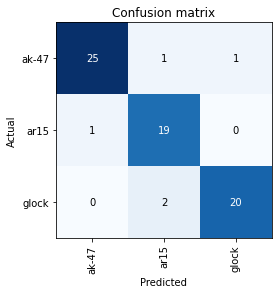

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

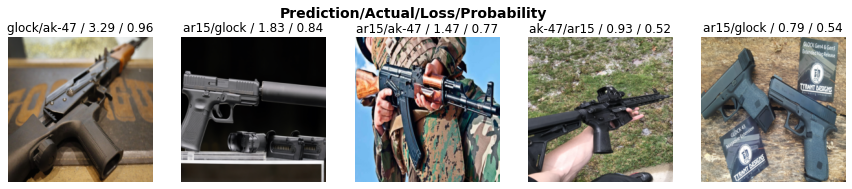

In [17]:
interp.plot_top_losses(5, nrows=1)

In [18]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [20]:
img = PILImage.create(btn_upload.data[-1])

In [21]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [22]:
pred, pred_idx, probs = learn.predict(img)

In [23]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: ak-47; Probability: 0.9988')

In [24]:
btn_run = widgets.Button(description="Classify")
btn_run

Button(description='Classify', style=ButtonStyle())

In [25]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [26]:
VBox([widgets.Label("Select your gun!"),
     btn_upload, btn_run, out_pl, lbl_pred])

In [27]:
learn.export()